In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os
import cv2
import random

In [2]:
!mkdir Training
!mkdir Training/no_tumor

In [ ]:
import zipfile

def create_zip(source_folder, destination_zip):
    with zipfile.ZipFile(destination_zip, 'w', zipfile.ZIP_DEFLATED) as zip_ref:
        for root, dirs, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                zip_ref.write(file_path, arcname=os.path.relpath(file_path, source_folder))

def extract_zip(zip_file, destination_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

source_folder = '/kaggle/input/brain-tumor-mri-dataset/Training/'
destination_zip = '/kaggle/working/folder.zip'
destination_folder = '/kaggle/working/Training/no_tumor'

create_zip(source_folder, destination_zip)
extract_zip(destination_zip, destination_folder)   

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224,224)), # Unify images to (224,224) size
    transforms.ToTensor()
])

train_dir='Training' ###### important
test_dir='/kaggle/input/brain-tumor-mri-dataset/Testing'

train_dataset = ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
class_names = test_dataset.classes

print(class_names)
print(len(train_dataset),len(test_dataset))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
395 394


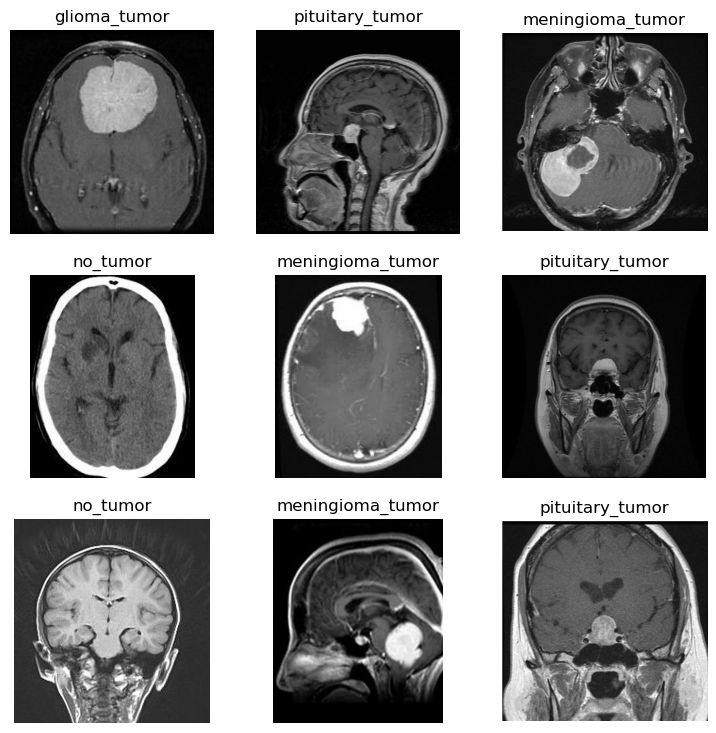

In [5]:
paths=[]
for dirname, _, filenames in os.walk('/kaggle/input/brain-tumor-classification-mri/Testing'):
    for filename in filenames:
        paths+=[(os.path.join(dirname, filename))]
paths=random.sample(paths,9)

fig, axs = plt.subplots(3,3,figsize=(9,9))
for i in range(9):
    r=i//3
    c=i%3
    path=paths[i]
    img = plt.imread(path)
    label=path.split('/')[-2]
    ax=axs[r][c].axis("off")
    ax=axs[r][c].set_title(label)
    ax=axs[r][c].imshow(img)
    
plt.show()

In [6]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Instantiate Autoencoder and send to GPU
autoencoder = Autoencoder().to(device)

# Definition of loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [8]:
# training
for epoch in range(200):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = Variable(img).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(train_loader)))

Epoch [1], Loss: 0.0930
Epoch [2], Loss: 0.0886
Epoch [3], Loss: 0.0570
Epoch [4], Loss: 0.0262
Epoch [5], Loss: 0.0150
Epoch [6], Loss: 0.0128
Epoch [7], Loss: 0.0117
Epoch [8], Loss: 0.0110
Epoch [9], Loss: 0.0104
Epoch [10], Loss: 0.0096
Epoch [11], Loss: 0.0088
Epoch [12], Loss: 0.0085
Epoch [13], Loss: 0.0082
Epoch [14], Loss: 0.0081
Epoch [15], Loss: 0.0079
Epoch [16], Loss: 0.0077
Epoch [17], Loss: 0.0076
Epoch [18], Loss: 0.0076
Epoch [19], Loss: 0.0075
Epoch [20], Loss: 0.0074
Epoch [21], Loss: 0.0073
Epoch [22], Loss: 0.0073
Epoch [23], Loss: 0.0072
Epoch [24], Loss: 0.0072
Epoch [25], Loss: 0.0070
Epoch [26], Loss: 0.0070
Epoch [27], Loss: 0.0069
Epoch [28], Loss: 0.0069
Epoch [29], Loss: 0.0068
Epoch [30], Loss: 0.0067
Epoch [31], Loss: 0.0067
Epoch [32], Loss: 0.0066
Epoch [33], Loss: 0.0066
Epoch [34], Loss: 0.0065
Epoch [35], Loss: 0.0064
Epoch [36], Loss: 0.0064
Epoch [37], Loss: 0.0064
Epoch [38], Loss: 0.0063
Epoch [39], Loss: 0.0063
Epoch [40], Loss: 0.0062
Epoch [41

In [10]:
#### comparison bertween classes in test data
autoencoder.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_encodings = [[] for i in range(4)]
with torch.no_grad():
    for data in test_loader:
        img, label = data
        img = Variable(img).to(device)
        encoding = autoencoder.encoder(img)
        class_encodings[label.item()].append(encoding.cpu().numpy().ravel())

In [13]:
# test
from sklearn.metrics import classification_report
autoencoder.eval()
for criteria in [0.001,0.003,0.01,0.03,0.1]:
    y_pred=[]
    y_true=[]  
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            img = Variable(img).to(device)
            outputs = autoencoder(img)
            loss = criterion(outputs, img)
            test_loss += loss.item()
            for i in range(len(img)):
                lossi=criterion(outputs[i], img[i])
                y_pred+=[int(lossi.item()>criteria)] #ture(big loss)=1,false(smsll loss)=0
                y_true+=[int(label[i]>0)] #ture(not notmal)=1,false(normal)=0
    print('test_loss',test_loss)
    print('criteria: lossi.item()>',criteria)
    print(classification_report(y_true, y_pred, target_names=['Normal','Abnormal'], digits=4)) 


test_loss 0.1112276406493038
criteria: lossi.item()> 0.001
              precision    recall  f1-score   support

      Normal     0.7827    0.7565    0.6958       100
    Abnormal     0.7449    0.9932    0.8513       294

    accuracy                         0.7411       394
   macro avg     0.3724    0.4966    0.4257       394
weighted avg     0.5558    0.7411    0.6352       394

test_loss 0.1112276406493038
criteria: lossi.item()> 0.003
              precision    recall  f1-score   support

      Normal     0.2727    0.3600    0.3103       100
    Abnormal     0.7557    0.6735    0.7122       294

    accuracy                         0.5939       394
   macro avg     0.5142    0.5167    0.5113       394
weighted avg     0.6331    0.5939    0.6102       394

test_loss 0.1112276406493038
criteria: lossi.item()> 0.01
              precision    recall  f1-score   support

      Normal     0.2500    0.9500    0.3958       100
    Abnormal     0.6429    0.0306    0.0584       294

    a

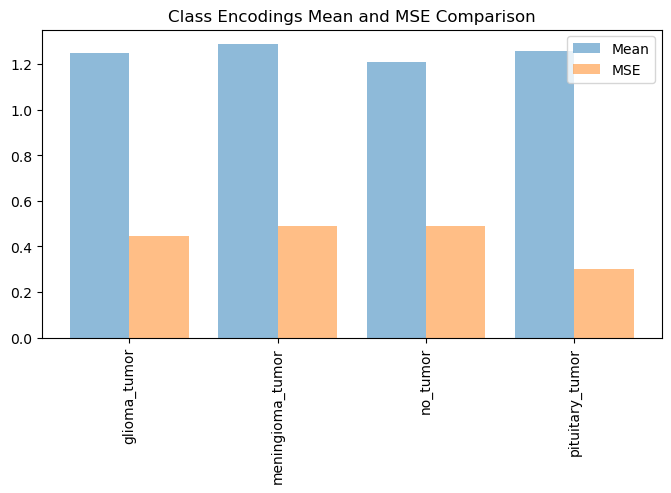

In [11]:
class_means = []
class_mses = []
for i in range(4):
    class_means.append(np.mean(class_encodings[i]))
    class_mse = np.mean((class_encodings[i] - class_means[i])**2)
    class_mses.append(class_mse)

plt.figure(figsize=(8,4))
plt.bar(np.arange(4)-0.2, class_means, width=0.4, label='Mean', alpha=0.5)
plt.bar(np.arange(4)+0.2, class_mses, width=0.4, label='MSE', alpha=0.5)
plt.xticks(range(4), class_names, rotation=90)
plt.legend()
plt.title("Class Encodings Mean and MSE Comparison")
plt.show()